# Scaling heavy DM sensitivity code to millions of sensors and beyond: Progress update

<i>Juehang Qin (qin106@purdue.edu), 19 Jul 2023</i>

In this note, I implement some collision code that will hopefully eventually allow for sensitivity projections from truly massive arrays. This is still in the testing phase, and I need to clean up some code, but I will eventually commit this to the usual repository: https://github.com/windchimeproject/windchime-quicksim

## Background

The issue we have faced thus far is one of both performance and memory. I would like this code to be performant up to 1 billion sensors, but with that many sensors, even just storing everything in memory becomes a challenge (~12 GB for 3 billion floats representing the sensor positions, before we even worry about anything else!) In addition, there is the issue of performance; it took ~10 mins to compute limits for a $10^3$ array. There are still some implementation efficiencies, but I doubt I can improve this by more than one order of magnitude, so this will not scale up to 1 billion sensors on CPU compute alone.

Individually these issues are easy to solve; the memory usage is not necessarily even a big issue when computing cluster nodes routinely have >100 GB of RAM (including the current server I'm working on), and GPUs can offer orders of magnitude of speedup relative to CPUs. However, GPUs don't have hundreds of GB of memory. In addition, the whole point of this work is to be lightweight and easy to run, so that it is easy to quickly evaluate the performance of different configurations, noise models, etc.; and I hope to extend that to the largest arrays we might plausibly consider, and maybe even to larger arrays that are experimentally implausible so that we can dream!

In [1]:
cd /home/juehang/Heavy\ DM\ sensitivity

/home/juehang/Heavy DM sensitivity


In [2]:
# %matplotlib widget
import numpy as np
from scipy import stats
import pickle
from functools import partial

from planckmc.track_generation import halo_model
from planckmc.track_generation import make_tracks

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import ticker
import windchime as chime
import pandas as pd

from numba import njit
from tqdm import tqdm, trange



/home/juehang/.conda/envs/strax_me/lib/python3.6/site-packages/wimprates/halo.py:144: RuntimeWarning: divide by zero encountered in true_divide
  / (2 * v_earth_t * v))


In [3]:
from scipy import constants
from scipy.integrate import quad
from scipy.optimize import fsolve
from scipy.special import kn
from scipy.interpolate import RegularGridInterpolator

In [4]:
import unittest

In [5]:
'''
Just initializes some constants.
'''

## universal constants - https://pdg.lbl.gov/2021/web/viewer.html?file=%2F2020/reviews/rpp2020-rev-phys-constants.pdf
G = constants.G #m^3/kg/s^2
amu = 1.6605390666e-27 #kg
k_B = constants.k #J/K
GeV_per_c2 = 1.7826619218835431593e-27
v_dm = 220e3 #m/s
rho_dm = 0.3*GeV_per_c2*(100**3) #kg/m^3
# mass_dm = 2.176434e-8 #kg https://en.wikipedia.org/wiki/Planck_units
planck_mass = 2.176434e-8
mass_dm = 1
hbar = constants.hbar
c_light = constants.c

## Approach: A series of cubes

The general approach is this:
 1. A large sensor array is divided into cubic sub-arrays.
 2. Dark matter tracks are simulated via toyMC, and the intersection between cubic sub-arrays and the dark matter track is evaluated.
 3. The SNR of a dark matter track through each cubic sub-array is evaluated.
 4. SNRs belonging to a single track are summed in quadrature.

This approach is conservative, as it effectively ignores the signal from portions of an array far from tracks, and reduces the sensitivity somewhat.

 ### Cube-track intersection

 This is evaluated by considering the track passing through planar surfaces making up a cube.

In [6]:
def cube_intersection(start_point, end_point, cube_length):
    """
    Determine if a line segment defined by its starting and ending points intersects with a cube.

    Args:
    - start_point: An array of length 3 defining the starting point of the line segment.
    - end_point: An array of length 3 defining the ending point of the line segment.
    - cube_length: A scalar representing the length of one side of the cube.

    Returns:
    - intersects: A boolean indicating whether the line segment intersects with the cube.
    - entry_plane: An integer indicating which plane the line segment enters the cube through (0, 1, or 2).
    - exit_plane: An integer indicating which plane the line segment exits the cube through (0, 1, or 2).
    - entry_plane_t: A scalar representing the parameter value at which the line segment enters the cube.
    - exit_plane_t: A scalar representing the parameter value at which the line segment exits the cube.
    - entry_cube_intersect_coords: A list or array of length 3 representing the coordinates where the line segment enters the cube.
    - exit_cube_intersect_coords: A list or array of length 3 representing the coordinates where the line segment exits the cube.
    """

    direction_vector = end_point-start_point
    zero_vector = direction_vector==0
    direction_vector += zero_vector
    plane_distance = cube_length/2 #distance between x, y, and z planes representing cube, from origin.
    entry_sign = np.sign(start_point)
    entry_sign += entry_sign==0
    t_entry = np.array([
        (plane_distance*np.sign(entry_sign[0]) - start_point[0])/direction_vector[0],
        (plane_distance*np.sign(entry_sign[1]) - start_point[1])/direction_vector[1],
        (plane_distance*np.sign(entry_sign[2]) - start_point[2])/direction_vector[2]
    ])
    dimensions = np.arange(3)
    intersects_list = []
    entry_cube_intersect_coords_arr = np.zeros((3,3))
    for i in dimensions:
        t_thisloop = t_entry[i]
        entry_cube_intersect_coords_thisloop = start_point+direction_vector*t_thisloop
        indices_to_check = dimensions[dimensions != i]
        intersects_list.append(np.all(np.abs(entry_cube_intersect_coords_thisloop[indices_to_check]) < plane_distance))
        entry_cube_intersect_coords_arr[i] = entry_cube_intersect_coords_thisloop
    intersects = np.any(intersects_list)
    if not intersects:
        return intersects, 0, 0, 0, 0, np.array([0,0,0]), np.array([0,0,0])
    entry_plane = dimensions[intersects_list][np.argmin(t_entry[intersects_list])]
    entry_plane_t = np.min(t_entry[intersects_list])
    entry_cube_intersect_coords = entry_cube_intersect_coords_arr[intersects_list][np.argmin(t_entry[intersects_list])]
    exit_sign = np.sign(end_point)
    exit_sign += exit_sign==0
    t_exit = np.array([
        (plane_distance*np.sign(exit_sign[0]) - start_point[0])/direction_vector[0],
        (plane_distance*np.sign(exit_sign[1]) - start_point[1])/direction_vector[1],
        (plane_distance*np.sign(exit_sign[2]) - start_point[2])/direction_vector[2]
    ])
    exit_intersects_list = []
    exit_cube_intersect_coords_arr = np.zeros((3,3))
    for i in dimensions:
        t_thisloop = t_exit[i]
        exit_cube_intersect_coords_thisloop = start_point+direction_vector*t_thisloop
        indices_to_check = dimensions[dimensions != i]
        exit_intersects_list.append(np.all(np.abs(exit_cube_intersect_coords_thisloop[indices_to_check]) < plane_distance))
        exit_cube_intersect_coords_arr[i] = exit_cube_intersect_coords_thisloop
    exit_plane = dimensions[exit_intersects_list][np.argmax(t_exit[exit_intersects_list])]
    exit_plane_t = np.max(t_exit[exit_intersects_list])
    exit_cube_intersect_coords = exit_cube_intersect_coords_arr[exit_intersects_list][np.argmax(t_exit[exit_intersects_list])]
    return intersects, entry_plane, exit_plane, entry_plane_t, exit_plane_t, entry_cube_intersect_coords, exit_cube_intersect_coords
    

### Test-driven development

To try to minimise mistakes, I also made a unittest. The test code checks for collisions between cubes and tracks naively, by generating a dense set of points along the ray. We pass the test!

In [7]:
def brute_force_collision_check(start_point, end_point, cube_length, N_points):
    """
    Checks for collision between a line segment and a cube using brute force method.

    Parameters:
        start_point (numpy.array): The starting point of the line segment.
        end_point (numpy.array): The ending point of the line segment.
        cube_length (float): The length of one side of the cube.
        N_points (int): The number of points to be checked along the line segment.

    Returns:
        intersection_bool (bool): True if there is at least one intersection, False otherwise.
        distance_between_points (float): The distance between two consecutive points on the line segment.
        intersection_length (float): The total length of intersections between the line segment and the cube.
        points (numpy.array): An array of points along the line segment.
        intersection_bool_arr (numpy.array): An array indicating which points intersect with the cube.

    """
    direction_vector = end_point-start_point
    t_array = np.linspace(0,1,N_points)
    length = np.linalg.norm(direction_vector)
    distance_between_points = t_array[1]*length
    points = start_point + np.repeat([direction_vector], N_points, axis=0)*np.repeat([t_array], 3, axis=0).T
    plane_distance = cube_length/2
    intersection_bool_arr = np.logical_and(np.logical_and(np.abs(points[:,0]) < plane_distance, np.abs(points[:,1]) < plane_distance), np.abs(points[:,2]) < plane_distance)
    intersection_bool = np.any(intersection_bool_arr)
    intersection_length = np.sum(intersection_bool_arr)*distance_between_points
    return intersection_bool, distance_between_points, intersection_length, points, intersection_bool_arr

class TestCubeIntersection(unittest.TestCase):


    def testlinesegments(self):
        rng = np.random.default_rng(seed=42)
        #generate points on a unit sphere using numpy gaussian
        N_points = 20000
        points_on_sphere = rng.normal(size=(N_points, 3))
        #normalise points to unit sphere
        points_on_sphere = points_on_sphere/np.linalg.norm(points_on_sphere, axis=1).reshape(N_points,1)
        trials = 5000
        #during each trial, pick 2 points and randomly generate a cube size, and a sphere size that is larger than the cube diagonal.
        for i in range(trials):
            cube_length = np.random.rand()*50
            sphere_size = np.max([np.sqrt((cube_length/2)**2*3), np.random.rand()*cube_length*2])
            point_indices = rng.choice(np.arange(N_points), size=2, replace=False)
            start_point = sphere_size*points_on_sphere[point_indices[0]]
            end_point = sphere_size*points_on_sphere[point_indices[1]]
            intersects, entry_plane, exit_plane, entry_plane_t, exit_plane_t, entry_cube_intersect_coords, exit_cube_intersect_coords = cube_intersection(start_point, end_point, cube_length)
            intersects_check, distance_between_points, intersection_length_check, line_points_check, intersection_bool_check = brute_force_collision_check(start_point, end_point, cube_length, 10000)
            intersection_length = np.linalg.norm(exit_cube_intersect_coords - entry_cube_intersect_coords)
            if intersects_check:
                # print(np.abs(intersection_length - intersection_length_check), 2*distance_between_points)
                # print(start_point, end_point, cube_length)
                self.assertTrue(np.abs(intersection_length - intersection_length_check) < 2*distance_between_points)
                self.assertTrue(intersects)
                intersection_points_check = line_points_check[intersection_bool_check]
                self.assertTrue(np.linalg.norm(entry_cube_intersect_coords - intersection_points_check[0]) < distance_between_points)
                self.assertTrue(np.linalg.norm(exit_cube_intersect_coords - intersection_points_check[-1]) < distance_between_points)
            else:
                if intersects:
                    self.assertTrue(intersection_length < distance_between_points)

                    # if not intersection_length < distance_between_points:
                        # print(start_point, end_point, cube_length, intersection_length, distance_between_points)
                
            

In [8]:
unittest.main(argv=['first-arg-is-ignored'], exit=False)

.
----------------------------------------------------------------------
Ran 1 test in 3.235s

OK


### Eyeball check

Of course, we also can check if everything is working right by eye

In [9]:
start_point = np.array([2.17844279, -13.19396036, -7.35917611])
end_point = np.array([-3.0927506, -5.29717757,  13.97706978])
cube_length = 17.625121318937886

In [10]:
intersects_check, distance_between_points, intersection_length_check, line_points_check, intersection_bool_check = brute_force_collision_check(start_point, end_point, cube_length, 10000)

In [11]:
intersects, entry_plane, exit_plane, entry_plane_t, exit_plane_t, entry_cube_intersect_coords, exit_cube_intersect_coords = cube_intersection(start_point, end_point, cube_length)

In [43]:
def midpoints(x):
    '''
    From matplotlib examples https://matplotlib.org/3.7.2/api/_as_gen/mpl_toolkits.mplot3d.axes3d.Axes3D.voxels.html
    '''
    sl = ()
    for _ in range(x.ndim):
        x = (x[sl + np.index_exp[:-1]] + x[sl + np.index_exp[1:]]) / 2.0
        sl += np.index_exp[:]
    return x

In [44]:
x, y, z = (np.indices((10, 10, 10))-5)*cube_length/4
x_mp = midpoints(x)
y_mp = midpoints(y)
z_mp = midpoints(z)
cube1 = (x_mp < cube_length/2) & (y_mp < cube_length/2) & (z_mp < cube_length/2) & (x_mp > -cube_length/2) & (y_mp > -cube_length/2) & (z_mp > -cube_length/2)

In [45]:
x_mp.shape

(9, 9, 9)

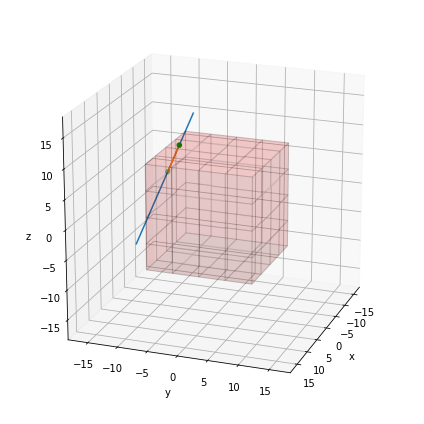

In [46]:
fig = plt.figure(figsize=(6,6))
fig.set_tight_layout(True)
ax = fig.add_subplot(111, projection='3d')
ax.voxels(x,y,z,cube1, facecolors='red', edgecolor=(0,0,0,0.1), alpha=0.1)
ax.plot([start_point[0], end_point[0]], [start_point[1], end_point[1]], [start_point[2], end_point[2]])
ax.plot(*(line_points_check[intersection_bool_check].T))
ax.scatter([entry_cube_intersect_coords[0], exit_cube_intersect_coords[0]], [entry_cube_intersect_coords[1], exit_cube_intersect_coords[1]], [entry_cube_intersect_coords[2], exit_cube_intersect_coords[2]], color='green')
ax.azim=110+270
ax.elev=20
ax.set(
    xlim=[-cube_length, cube_length],
    ylim=[-cube_length,cube_length],
    zlim=[-cube_length,cube_length],
    xlabel='x',
    ylabel='y',
    zlabel='z'
    )
plt.show()

In [51]:
start_point = np.array([0.1, -1, 0.1])
end_point = np.array([-0.1, 1,  0.05])
start_point = start_point/np.linalg.norm(start_point)*2
end_point = end_point/np.linalg.norm(end_point)*2

In [75]:
N_cubes_per_side = 5
spacing = 0.2
cube_length = N_cubes_per_side*spacing
edge_coordinates = (np.indices((N_cubes_per_side+1, N_cubes_per_side+1, N_cubes_per_side+1))-N_cubes_per_side/2)*spacing
cube_centres_x = midpoints(edge_coordinates[0])
cube_centres_y = midpoints(edge_coordinates[1])
cube_centres_z = midpoints(edge_coordinates[2])

In [79]:
cubes_bool = np.zeros_like(cube_centres_x, dtype='bool')
for i in trange(N_cubes_per_side):
    for j in range(N_cubes_per_side):
        for k in range(N_cubes_per_side):
            center_coord_this_loop = np.array([cube_centres_x[i,j,k], cube_centres_y[i,j,k], cube_centres_z[i,j,k]])
            offset_start_point = start_point - center_coord_this_loop
            offset_end_point = end_point - center_coord_this_loop
            intersects, entry_plane, exit_plane, entry_plane_t, exit_plane_t, entry_cube_intersect_coords, exit_cube_intersect_coords = cube_intersection(offset_start_point, offset_end_point, spacing)
            cubes_bool[i,j,k] = intersects

100%|██████████| 5/5 [00:00<00:00, 266.71it/s]


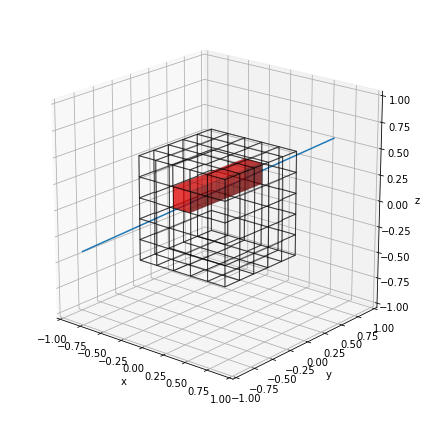

In [84]:
fig = plt.figure(figsize=(6,6))
fig.set_tight_layout(True)
ax = fig.add_subplot(111, projection='3d')
ax.voxels(*edge_coordinates,cubes_bool, facecolors='red', edgecolor=(0,0,0,0.1), alpha=0.5)
ax.voxels(*edge_coordinates,np.zeros_like(cubes_bool)+1, facecolors='red', edgecolor=(0,0,0,0.5), alpha=0.0)
ax.plot([start_point[0], end_point[0]], [start_point[1], end_point[1]], [start_point[2], end_point[2]])
# ax.plot(*(line_points_check[intersection_bool_check].T))
# ax.scatter([entry_cube_intersect_coords[0], exit_cube_intersect_coords[0]], [entry_cube_intersect_coords[1], exit_cube_intersect_coords[1]], [entry_cube_intersect_coords[2], exit_cube_intersect_coords[2]], color='green')
ax.azim=40+270
ax.elev=20
ax.set(
    xlim=[-cube_length, cube_length],
    ylim=[-cube_length,cube_length],
    zlim=[-cube_length,cube_length],
    xlabel='x',
    ylabel='y',
    zlabel='z'
    )
plt.show()

## Limit setting

The limit setting proceeds as I have presented in earlier meetings, but the SNR is evaluated on sub-arrays, and then summed later in quadrature.

In [86]:
'''
Just initializes some constants.
'''

## universal constants - https://pdg.lbl.gov/2021/web/viewer.html?file=%2F2020/reviews/rpp2020-rev-phys-constants.pdf
G = constants.G #m^3/kg/s^2
amu = 1.6605390666e-27 #kg
k_B = constants.k #J/K
GeV_per_c2 = 1.7826619218835431593e-27
v_dm = 220e3 #m/s
rho_dm = 0.3*GeV_per_c2*(100**3) #kg/m^3
# mass_dm = 2.176434e-8 #kg https://en.wikipedia.org/wiki/Planck_units
planck_mass = 2.176434e-8
mass_dm = 1
hbar = constants.hbar
c_light = constants.c

In [95]:
class windchime_experiment:
    N_sensors_x = 2 #sub-array
    N_sensors_y = 2 #sub-array
    N_sensors_z = 2 #sub-array
    length = 0.3 #m, sub-array
    N_sub_arrays = 1
    sensor_mass = 5e-9 #kg
    sensor_density = 1.134e4 #kg/m^3
    resonance_freq = 200/(2*np.pi) #Hz
    sensor_Q = 3e7
    QNR=1
    gas_pressure = 1e-10
    T = 15e-3
    A = 207.2 #Pb
    S_xx = 1e-18 #m^2/Hz
    noise_model = 'squid'
    A_squid = 45
    B = 1e-7
    freq_term = 0
    def __init__(self, **kwargs):
        if 'N_sensors_x' in kwargs:
            self.N_sensors_x = kwargs['N_sensors_x']
        if 'N_sensors_y' in kwargs:
            self.N_sensors_y = kwargs['N_sensors_y']
        if 'N_sensors_z' in kwargs:
            self.N_sensors_z = kwargs['N_sensors_z']
        if 'N_sub_arrays' in kwargs:
            self.N_sub_arrays = kwargs['N_sub_arrays']
        if 'sensor_mass' in kwargs:
            self.sensor_mass = kwargs['sensor_mass']
        if 'resonance_freq' in kwargs:
            self.resonance_freq = kwargs['resonance_freq']
        if 'sensor_Q' in kwargs:
            self.sensor_Q = kwargs['sensor_Q']
        if 'QNR' in kwargs:
            self.QNR = kwargs['QNR']
        if 'length' in kwargs:
            self.length = kwargs['length']
        if 'S_xx' in kwargs:
            self.S_xx = kwargs['S_xx']
        if 'noise_model' in kwargs:
            self.noise_model = kwargs['noise_model']
        if 'A_squid' in kwargs:
            self.A_squid = kwargs['A_squid']
        if 'B' in kwargs:
            self.B = kwargs['B']
        if 'freq_term' in kwargs:
            self.freq_term = kwargs['freq_term']
        self.r = (self.sensor_mass/self.sensor_density/4*3/np.pi)**(1/3)
        self.A_d = self.r**2*np.pi
        self.beta = self.gas_pressure*self.A_d*np.sqrt(4*amu*k_B*self.T)/self.sensor_mass**2

In [88]:
def measurement_noise(w, f_m, Q, sensor_mass, A, B, freq_term):
    w_m = f_m*2*np.pi
    gamma = float(w_m) / float(Q)
    abs_xm = abs((1/sensor_mass**2)/((w**2-w_m**2)**2+(gamma**2)*w**2))#checked. 

    return B*A*(1+freq_term/w)*hbar/(sensor_mass*gamma*w_m*abs_xm)
               
def back_action(w, f_m, Q, sensor_mass, A, B, freq_term):
    w_m = f_m*2*np.pi
    gamma = float(w_m) / float(Q)
    return sensor_mass*gamma*w_m*A*(1+freq_term/w)*hbar/B

def thermal_noise(sensor_mass, gas_pressure, A_d, Q, f_m, T=4):
    '''Get impulse noise array from array of b'''
    return 4*k_B*sensor_mass*T*(f_m*2*np.pi/Q) + gas_pressure*A_d*np.sqrt(4*amu*k_B*T)

In [89]:
def signal_model(w, b, v):
    return 2*(w)**2/(np.pi*v**4)*(kn(1, w*b/v)**2)

In [90]:
def integrand_signal_model_exponential(integral_var, b, v, T, f_m, Q, gas_pressure, A_d, sensor_mass, A, B, freq_term):
    w = np.exp(integral_var)
    N = (
        measurement_noise(w, f_m, Q, sensor_mass, A, B, freq_term) +
        back_action(w, f_m, Q, sensor_mass, A, B, freq_term) +
        thermal_noise(sensor_mass, gas_pressure, A_d, Q, f_m, T)
    )
    S_sq = signal_model(w, b=b, v=v)
    return S_sq/N*w

In [91]:
def numerical_SNR(b, v, T, f_m, Q, gas_pressure, A_d, sensor_mass, A, B, freq_term):
    return quad(integrand_signal_model_exponential, -30, 40, args=( b, v, T, f_m, Q, gas_pressure, A_d, sensor_mass, A, B, freq_term), points=[np.log(2*np.pi*f_m*0.99), np.log(2*np.pi*f_m), np.log(2*np.pi*f_m*1.01)])[0]

In [92]:
b_arr = np.logspace(-3, 1, 100)
v_arr = np.logspace(0, 6, 101)

b_mat, v_mat = np.meshgrid(b_arr, v_arr)

test_setup = windchime_experiment()
SNRs = np.zeros_like(b_mat)
for i in trange(len(v_arr)):
    for j in range(len(b_arr)):
        SNRs[i,j] = numerical_SNR(b_mat[i,j], v_mat[i,j], test_setup.T, test_setup.resonance_freq, test_setup.sensor_Q, test_setup.gas_pressure, test_setup.A_d, test_setup.sensor_mass, test_setup.A, test_setup.B, test_setup.freq_term)

100%|██████████| 101/101 [01:14<00:00,  1.35it/s]


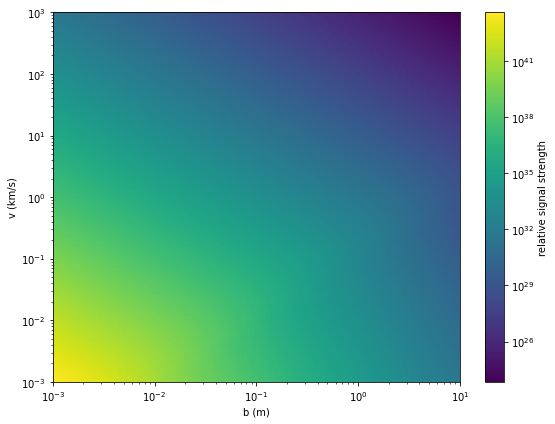

In [93]:
fig = plt.figure(figsize=(8,6))
fig.set_tight_layout(True)
ax = fig.add_subplot(111)
pc = ax.pcolormesh(b_mat, v_mat/1e3, SNRs, norm=LogNorm())
cb = plt.colorbar(pc)
ax.set(xlabel='b (m)', ylabel='v (km/s)', xscale='log', yscale='log')
cb.ax.set(ylabel=r'relative signal strength')
plt.show()

In [94]:
SNR_func = RegularGridInterpolator((np.log(v_arr),np.log(b_arr)), np.log(SNRs), method='linear', fill_value=0, bounds_error=False)

In [216]:
def generate_tracks_for_subarrays(experiment_setup, N=10000, radius_multiplier=1):
    subarray_length = experiment_setup.length
    vel = halo_model.generate_vel_array(n_vels=N)
    N_sub_arrays = experiment_setup.N_sub_arrays
    radius = subarray_length*N_sub_arrays*radius_multiplier
    entry_vecs, exit_vecs, t_entry, t_exit = make_tracks.generate_tracks(vel, np.zeros(vel.shape), radius=radius)
    spacing = subarray_length
    edge_coordinates = (np.indices((N_sub_arrays+1, N_sub_arrays+1, N_sub_arrays+1))-N_sub_arrays/2)*spacing
    cube_centres_x = midpoints(edge_coordinates[0])
    cube_centres_y = midpoints(edge_coordinates[1])
    cube_centres_z = midpoints(edge_coordinates[2])
    subarr_entry_vec_list = []
    subarr_exit_vec_list = []
    subarr_track_indices = []
    subarr_vels = []
    for i_track in trange(N):
        cubes_bool = np.zeros_like(cube_centres_x, dtype='bool')
        for i in range(N_sub_arrays):
            for j in range(N_sub_arrays):
                for k in range(N_sub_arrays):
                    center_coord_this_loop = np.array([cube_centres_x[i,j,k], cube_centres_y[i,j,k], cube_centres_z[i,j,k]])
                    offset_start_point = entry_vecs[:, i_track] - center_coord_this_loop
                    offset_end_point = exit_vecs[:, i_track] - center_coord_this_loop
                    intersects, entry_plane, exit_plane, entry_plane_t, exit_plane_t, entry_cube_intersect_coords, exit_cube_intersect_coords = cube_intersection(offset_start_point, offset_end_point, spacing)
                    cubes_bool[i,j,k] = intersects
                    # import pdb; pdb.set_trace()
                    if intersects:
                        subarr_entry_vec_list.append(offset_start_point)
                        subarr_exit_vec_list.append(offset_end_point)
                        subarr_track_indices.append(i_track)
                        subarr_vels.append(vel[i_track])
    return radius, np.array(subarr_vels), np.array(subarr_entry_vec_list).T , np.array(subarr_exit_vec_list).T, np.array(subarr_track_indices)


In [217]:
gen1 = windchime_experiment(length=0.6, N_sensors_x=3, N_sensors_y=3, N_sensors_z=3, sensor_mass=1e-3, sensor_Q=1e9, resonance_freq=10, N_sub_arrays=5)

In [219]:
def generate_limits(experiment_setup, N=10000, alpha_bins_edges=np.logspace(-30, -10, 50), mass_dm_bins_edges=np.logspace(-12, -7, 48), max_sensitivity_toymc_trials=10000, sensitivity_toymc_trial_multiplier=500, exposure=1, SNR_threshold=10, b_bins=100, v_bins=99, radius_multiplier=1):
    '''
    Exposure in years.
    '''
    
    N_sensors_x = experiment_setup.N_sensors_x
    N_sensors_y = experiment_setup.N_sensors_y
    N_sensors_z = experiment_setup.N_sensors_z
    N_sub_arrays = experiment_setup.N_sub_arrays
    length_x = length_y = length_z = experiment_setup.length #meter
    spacing = length_x/(N_sensors_x - 1)
    # radius = np.max((length_x, length_y, length_z))*2 #metre
    sensor_mass = experiment_setup.sensor_mass
    sensor_density = experiment_setup.sensor_density
    sensor_coords = np.zeros((3, N_sensors_x*N_sensors_y*N_sensors_z))
    coords_1d = (
        np.linspace(-length_x/2 + length_x/(2*N_sensors_x), length_x/2 - length_x/(2*N_sensors_x), N_sensors_x),
        np.linspace(-length_y/2 + length_x/(2*N_sensors_y), length_y/2 - length_x/(2*N_sensors_y), N_sensors_y),
        np.linspace(-length_z/2 + length_x/(2*N_sensors_z), length_z/2 - length_x/(2*N_sensors_z), N_sensors_z),
    )
    noise_model = experiment_setup.noise_model
    x, y, z = np.meshgrid(*coords_1d, indexing='ij')
    
    sensor_coords[0,:] = x.ravel()
    sensor_coords[1,:] = y.ravel()
    sensor_coords[2,:] = z.ravel()

    sensor_vectors = np.repeat([[0,0,1]], sensor_coords.shape[1], axis=0).T #orientation vectors
    min_impact_parameter = experiment_setup.r #metres
    gas_pressure = experiment_setup.gas_pressure #Pa

    A_d = experiment_setup.A_d
    beta = experiment_setup.beta
    sensor_Q = experiment_setup.sensor_Q
    QNR = experiment_setup.QNR
    resonance_freq = experiment_setup.resonance_freq
    A_squid = experiment_setup.A_squid
    B = experiment_setup.B
    #make tracks
    # vel = halo_model.generate_vel_array(n_vels=N)
    # entry_vecs, exit_vecs, t_entry, t_exit = make_tracks.generate_tracks(vel, np.zeros(vel.shape), radius=radius)
    
    # velocity = vel

    radius, velocity, position_entry, position_exit, subarr_track_indices = generate_tracks_for_subarrays(experiment_setup, N=N, radius_multiplier=radius_multiplier)
    
    #todo: make new track_parameters array when N_sub_arrays>1, for individual sub-arrays based on collision.
    #Then make an array of indices tracking the tracks so that they can be merged later.

    # position_entry = entry_vecs
    # position_exit = exit_vecs

    track_parameters = np.vstack((velocity, position_entry, position_exit))
    
    
    NUMBER_OF_BINS = 10000
    BINS_B = np.logspace(-10, np.log10(np.sqrt(3) * 2 * length_x), NUMBER_OF_BINS)
    BINS_SNR = np.linspace(0, 1e8, NUMBER_OF_BINS)
    
    T = experiment_setup.T
    
    # compute signal strengths
    if noise_model == 'squid':
        b_arr = np.logspace(np.log(min_impact_parameter)/np.log(10)-0.1, np.log(radius)/np.log(10)+0.5, b_bins)
        v_arr = np.logspace(np.log(np.min(vel))/np.log(10)-0.1, np.log(np.max(vel))/np.log(10)+0.1, v_bins)
        b_mat, v_mat = np.meshgrid(b_arr, v_arr)
        norm_SNRs = np.zeros_like(b_mat)
        for i in trange(len(v_arr)):
            for j in range(len(b_arr)):
                norm_SNRs[i,j] = numerical_SNR(b_mat[i,j], v_mat[i,j], T, resonance_freq, sensor_Q, gas_pressure, A_d, sensor_mass, experiment_setup.A_squid, experiment_setup.B, experiment_setup.freq_term)
        SNR_func = RegularGridInterpolator((np.log(v_arr),np.log(b_arr)), np.log(norm_SNRs), method='linear', fill_value=0, bounds_error=False)
        signal_func = partial(chime.signal_interpolation_func, SNR_func=SNR_func) 
        individual_snrs, individual_b, signal_array, b_array = chime.simulate(track_parameters, sensor_vectors, sensor_coords, sensor_mass, min_impact_parameter, beta, mass_dm=mass_dm, bins_snr=BINS_SNR, bins_b=BINS_B, all_sensor_values = True, signal=signal_func, check_assertions=False)
    else:
        individual_snrs, individual_b, signal_array, b_array = chime.simulate(track_parameters, sensor_vectors, sensor_coords, sensor_mass, min_impact_parameter, beta, mass_dm=mass_dm, bins_snr=BINS_SNR, bins_b=BINS_B, all_sensor_values = True, signal=chime.signal_without_template_matching, check_assertions=False)
    
    alpha_bins = alpha_bins_edges[:-1] + np.diff(alpha_bins_edges)/2
    mass_dm_bins = mass_dm_bins_edges[:-1] + np.diff(mass_dm_bins_edges)/2
    
    fraction_with_detections = np.zeros((len(mass_dm_bins), len(alpha_bins)))
    if noise_model == 'classical':
        impulse_noise_arr = chime.impulse_noise_classical(b_array, sensor_mass, gas_pressure, A_d, sensor_Q, resonance_freq, T=T, S_xx=experiment_setup.S_xx)
    elif noise_model == 'quantum':
        impulse_noise_arr = chime.impulse_noise(b_array, sensor_mass, gas_pressure, A_d, sensor_Q, resonance_freq, T=T, QNR=experiment_setup.QNR)
    elif noise_model == 'squid':
        pass
    else:
        raise ValueError(f'Specified noise model {noise_model} is invalid.')
    for i, mass_dm_thisloop in enumerate(tqdm(mass_dm_bins)):
        for j, alpha in enumerate(alpha_bins):
            expected_rate_through_radius = rho_dm*v_dm/mass_dm_thisloop*3600*24*365*np.pi*radius**2 #events per year
            if noise_model == 'squid':
                SNRs = np.sqrt(np.sum(signal_array, axis=0))/(G*mass_dm)*(alpha)
            else:
                SNRs = chime.SNRs_from_S_and_impulse_noise(signal_array, impulse_noise_arr, sensor_mass)/(G*mass_dm*sensor_mass)*(alpha)
            SNRs = np.sqrt(np.bincount(subarr_track_indices, SNRs**2))
            detected = np.sum(SNRs > SNR_threshold)
            pdf_parameters_thisloop = (detected+0.5, N+0.5-detected)
            sensitivity_toymc_trials = np.min((np.round(expected_rate_through_radius*exposure*sensitivity_toymc_trial_multiplier).astype(int), max_sensitivity_toymc_trials))
            detected_particles = chime.toy_MC_poisson_detection(expected_rate_through_radius*exposure, pdf_parameters_thisloop, trials=sensitivity_toymc_trials)
            fraction_with_detections[i,j] = np.sum(detected_particles > 0)/sensitivity_toymc_trials

    return (
        [alpha_bins_edges, alpha_bins],
        [mass_dm_bins_edges, mass_dm_bins],
        fraction_with_detections
    )

In [220]:
plt.rcParams.update({
    'font.family': 'serif',
    'figure.dpi': 500,
    'mathtext.fontset': 'dejavuserif',
    'font.size': 10.0
})

In [221]:
def kgtogev(x):
    return x/GeV_per_c2

def gevtokg(x):
    return x*GeV_per_c2

In [222]:
gen1 = windchime_experiment(length=0.6, N_sensors_x=3, N_sensors_y=3, N_sensors_z=3, sensor_mass=1e-3, sensor_Q=1e7, resonance_freq=1)
gen2 = windchime_experiment(length=0.6, N_sensors_x=3, N_sensors_y=3, N_sensors_z=3, sensor_mass=1e-3, sensor_Q=1e7, resonance_freq=1, N_sub_arrays=2)
gen3 = windchime_experiment(length=0.6, N_sensors_x=3, N_sensors_y=3, N_sensors_z=3, sensor_mass=1e-3, sensor_Q=1e7, resonance_freq=1, N_sub_arrays=5)

# gen1_DC = windchime_experiment(length=0.6, N_sensors_x=3, N_sensors_y=1, N_sensors_z=1, sensor_mass=1e-3, sensor_Q=1e9, resonance_freq=10, freq_term=2*np.pi*1000)
# gen2_DC = windchime_experiment(length=0.6, N_sensors_x=3, N_sensors_y=1, N_sensors_z=1, sensor_mass=1e-3, sensor_Q=1e8, resonance_freq=1, freq_term=2*np.pi*1000)
# gen3_DC = windchime_experiment(length=0.6, N_sensors_x=3, N_sensors_y=1, N_sensors_z=1, sensor_mass=1e-3, sensor_Q=1e7, resonance_freq=0.1, freq_term=2*np.pi*1000)


# gen1 = windchime_experiment(length=1)
# gen2 = windchime_experiment(length=1)
# gen3 = windchime_experiment(length=100)

# mass_dm_bins_edges = np.logspace(-13, -7, 91)
mass_dm_bins_edges = np.logspace(-13, -7, 25)
# mass_dm_bins_edges = np.logspace(-13, -7, 50)

# alpha_bins_edges=np.logspace(-19, -5, 160)
alpha_bins_edges=np.logspace(-19, -5, 40)
# alpha_bins_edges=np.logspace(-19, -5, 90)

# b_bins=100
# v_bins=99

b_bins=60
v_bins=50

alpha_bin_list, mass_bin_list, fraction_with_detections_g1 = generate_limits(gen1, mass_dm_bins_edges=mass_dm_bins_edges, alpha_bins_edges=alpha_bins_edges, max_sensitivity_toymc_trials=30000, N=10000, exposure=2/52, sensitivity_toymc_trial_multiplier=4000, b_bins=b_bins, v_bins=v_bins)
alpha_bin_list, mass_bin_list, fraction_with_detections_g2 = generate_limits(gen2, mass_dm_bins_edges=mass_dm_bins_edges, alpha_bins_edges=alpha_bins_edges, max_sensitivity_toymc_trials=30000, N=10000, exposure=2/52, sensitivity_toymc_trial_multiplier=4000, b_bins=b_bins, v_bins=v_bins)
alpha_bin_list, mass_bin_list, fraction_with_detections_g3 = generate_limits(gen3, mass_dm_bins_edges=mass_dm_bins_edges, alpha_bins_edges=alpha_bins_edges, max_sensitivity_toymc_trials=30000, N=10000, exposure=2/52, sensitivity_toymc_trial_multiplier=4000, b_bins=b_bins, v_bins=v_bins)

# alpha_bin_list, mass_bin_list, fraction_with_detections_g1_DC = generate_limits(gen1_DC, mass_dm_bins_edges=mass_dm_bins_edges, alpha_bins_edges=alpha_bins_edges, max_sensitivity_toymc_trials=30000, N=40000, exposure=2/52, sensitivity_toymc_trial_multiplier=4000, b_bins=b_bins, v_bins=v_bins)
# alpha_bin_list, mass_bin_list, fraction_with_detections_g2_DC = generate_limits(gen2_DC, mass_dm_bins_edges=mass_dm_bins_edges, alpha_bins_edges=alpha_bins_edges, max_sensitivity_toymc_trials=30000, N=40000, exposure=2/52, sensitivity_toymc_trial_multiplier=4000, b_bins=b_bins, v_bins=v_bins)
# alpha_bin_list, mass_bin_list, fraction_with_detections_g3_DC = generate_limits(gen3_DC, mass_dm_bins_edges=mass_dm_bins_edges, alpha_bins_edges=alpha_bins_edges, max_sensitivity_toymc_trials=30000, N=40000, exposure=2/52, sensitivity_toymc_trial_multiplier=4000, b_bins=b_bins, v_bins=v_bins)

100%|██████████| 24/24 [00:07<00:00,  3.26it/s]


In [223]:
mass_dm_bins_edges, mass_dm_bins = mass_bin_list
alpha_bins_edges, alpha_bins = alpha_bin_list
alpha_grav = G*mass_dm_bins_edges*(amu)/(hbar*c_light)*gen1.A

In [224]:
xenon_limit = pd.read_csv('mass_alpha_xe1t.csv')

In [225]:
A_xenon = 131.293
A_gen1 = gen1.sensor_mass/amu
A_gen2 = gen2.sensor_mass/amu
A_gen3 = gen3.sensor_mass/amu

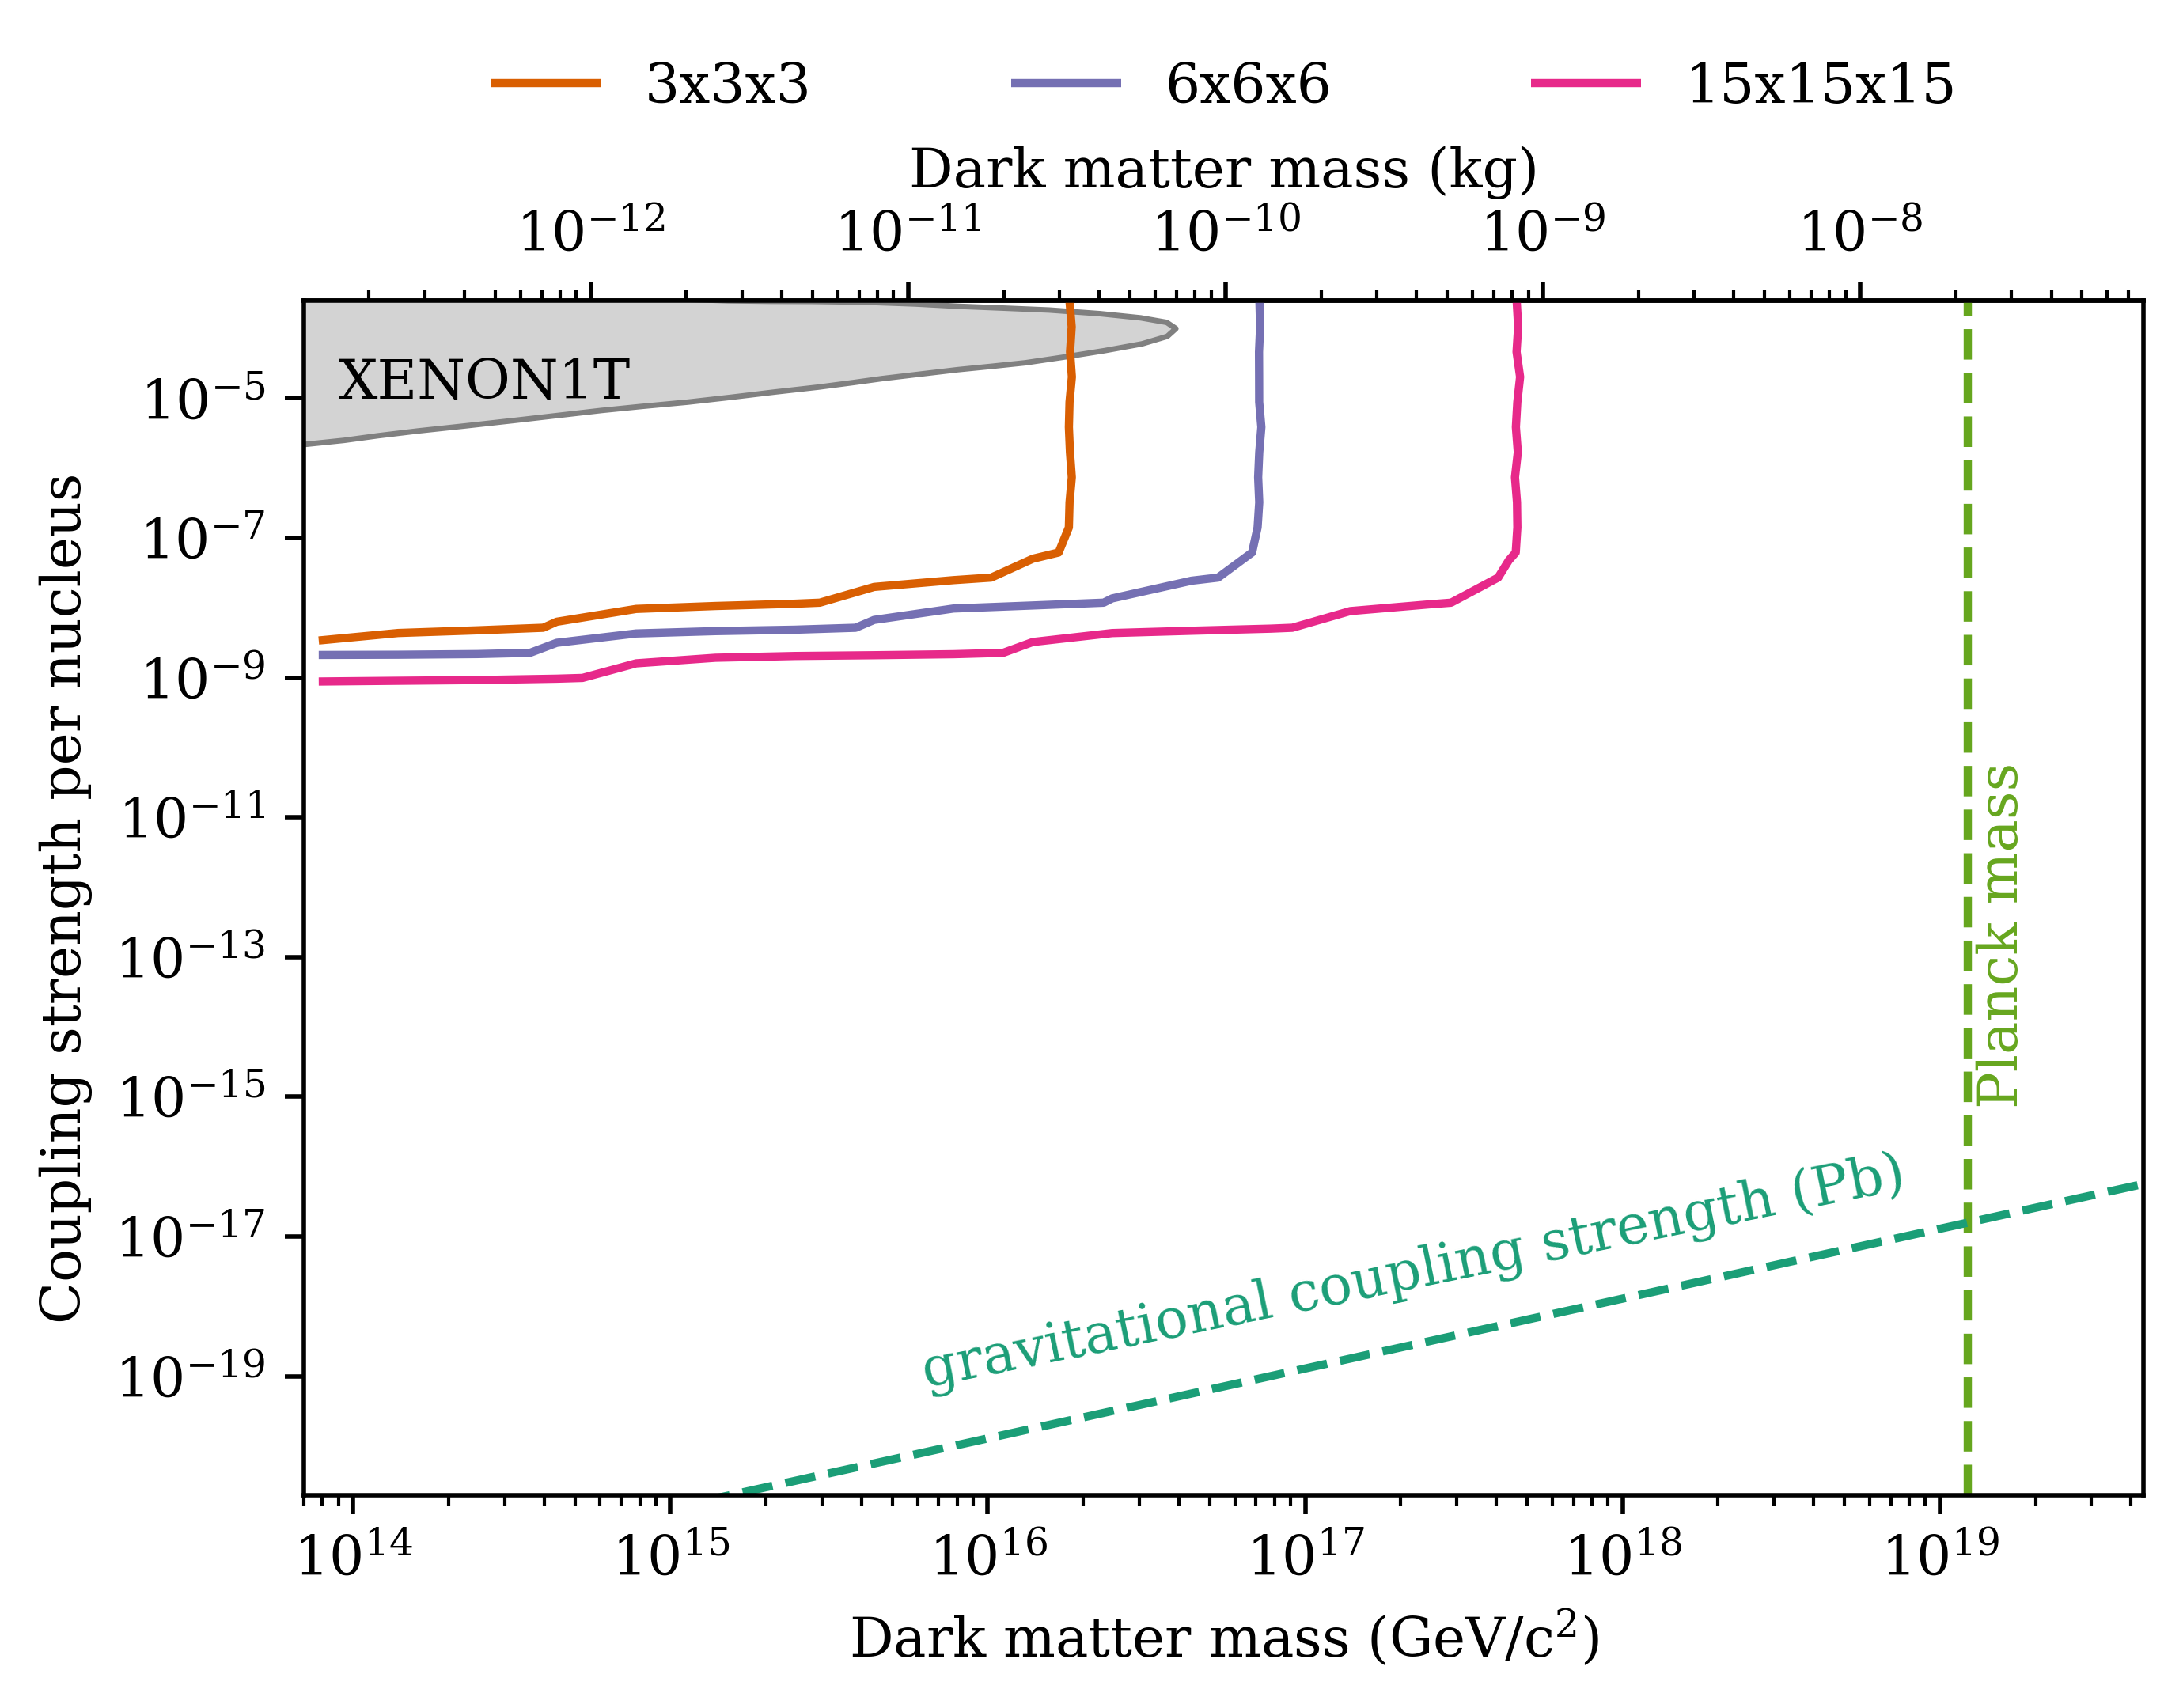

In [226]:
# ylim=[2e-11, 2.5e-4]
ylim=[2e-21, 2.5e-4]
xlim=[7e13, kgtogev(np.max(mass_dm_bins))]

X,Y = np.meshgrid(mass_dm_bins_edges, alpha_bins_edges, indexing='ij')
X_points,Y_points = np.meshgrid(mass_dm_bins, alpha_bins, indexing='ij')
cmap = cm.get_cmap('magma')
cmap_integer = cm.get_cmap('Dark2')
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
c1 = ax.contour(kgtogev(X_points), Y_points/(A_gen1*hbar*c_light)*gen1.A, fraction_with_detections_g1, [0.9], colors=[cmap_integer(1)])
c2 = ax.contour(kgtogev(X_points), Y_points/(A_gen2*hbar*c_light)*gen2.A, fraction_with_detections_g2, [0.9], colors=[cmap_integer(2)])
c3 = ax.contour(kgtogev(X_points), Y_points/(A_gen3*hbar*c_light)*gen3.A, fraction_with_detections_g3, [0.9], colors=[cmap_integer(3)])

# c1_DC = ax.contour(kgtogev(X_points), Y_points/(A_gen1*hbar*c_light)*gen1.A, fraction_with_detections_g1_DC, [0.9], colors=[cmap_integer(1)], linestyles='dotted')
# c2_DC = ax.contour(kgtogev(X_points), Y_points/(A_gen2*hbar*c_light)*gen2.A, fraction_with_detections_g2_DC, [0.9], colors=[cmap_integer(2)], linestyles='dotted')
# c3_DC = ax.contour(kgtogev(X_points), Y_points/(A_gen3*hbar*c_light)*gen3.A, fraction_with_detections_g3_DC, [0.9], colors=[cmap_integer(3)], linestyles='dotted')

# c1_DC = ax.contour(kgtogev(X_points), Y_points/(A_gen1*hbar*c_light)*gen1.A, abcdef, [0.9], colors=[cmap_integer(1)], linestyles='dotted')


ax.plot(kgtogev(mass_dm_bins_edges), alpha_grav, c=cmap_integer(0), linestyle='--')
ax.text(6e15, 7e-20, 'gravitational coupling strength (Pb)', rotation=11.5, c=cmap_integer(0))

ax.vlines(x=[kgtogev(planck_mass)], ymin=ylim[0], ymax=ylim[1], linestyle='--', color=cmap_integer(4))
ax.text(1.3e19, 1e-15, 'Planck mass', rotation=90, c=cmap_integer(4))

secax = ax.secondary_xaxis('top', functions=(gevtokg, kgtogev))
secax.set_xlabel('Dark matter mass (kg)')

# ax.text(1.5e17, 4e-7, 'Fifth force searches', rotation=0, color=(0.5, 0.6, 0.7))
# ax.fill_between(x=kgtogev(mass_dm_bins_edges), y1=1, y2=5e-6, facecolor=(0.7, 0.8, 0.9), edgecolor=(0.5, 0.6, 0.7))

ax.fill_betweenx(x1=kgtogev(xenon_limit['mass_kg'].values), y=xenon_limit['alpha'].values, facecolor='lightgrey', edgecolor='grey')
ax.text(9e13, 1e-5, 'XENON1T', rotation=0, color='k')

ax.set(xlabel=r'Dark matter mass ($\mathrm{GeV/c^2}$)', ylabel='Coupling strength per nucleus', xscale='log', yscale='log', xlim=xlim, ylim=ylim)
# ax.yaxis.set_minor_locator(ticker.LogLocator(base=10))
# ax.yaxis.set_major_locator(ticker.LogLocator(base=10, subs=[1], numticks=30))
# ax.minorticks_on()

h1,_ = c1.legend_elements()
h2,_ = c2.legend_elements()
h3,_ = c3.legend_elements()
# ax.legend()
plt.legend([h1[0], h2[0], h3[0]], ['3x3x3', '6x6x6', '15x15x15'], bbox_to_anchor=(0,1,1,0.1),  loc="lower left", 
           borderaxespad=3, ncol=3, frameon=False, mode='expand')

# plt.legend([h1[0], h2[0]], ['10 Hz', '1 Hz'], bbox_to_anchor=(0,1,1,0.1),  loc="lower left", 
#            borderaxespad=3, ncol=3, frameon=False, mode='expand')

ax.yaxis.set_tick_params(which='minor', length=4, color='r', width=1)
# plt.savefig('Gerard_mw_squid_sensitivity.pdf'
#             , bbox_inches='tight'
#            )
plt.show()

The curves generated took about 1 minute each! The reason why I used array sizes much smaller than the million arrays I promised is because I am still making sure the code is working well, and this involves comparing these limits with older code to make sure there are no new regressions.